In [32]:
import os
import sys
import pandas as pd 
import collections
import json
import numpy as np
from os.path import abspath
from sklearn.model_selection import train_test_split
import torch
import torch.nn.functional as F 
import torch.nn as nn
import torch.autograd as autograd 
import torch.optim as optim 
import matplotlib.pyplot as plt

In [2]:
from google.colab import drive

drive.mount('/content/drive')

Mounted at /content/drive


### Reading the Data 

In [3]:
data = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/ner.csv", encoding="ISO-8859-1", error_bad_lines=False) 

b'Skipping line 281837: expected 25 fields, saw 34\n'


In [4]:
data.head(5)

,Unnamed: 0,lemma,next-lemma,next-next-lemma,next-next-pos,next-next-shape,next-next-word,next-pos,next-shape,next-word,pos,prev-iob,prev-lemma,prev-pos,prev-prev-iob,prev-prev-lemma,prev-prev-pos,prev-prev-shape,prev-prev-word,prev-shape,prev-word,sentence_idx,shape,word,tag
0,0,thousand,of,demonstr,NNS,lowercase,demonstrators,IN,lowercase,of,NNS,__START1__,__start1__,__START1__,__START2__,__start2__,__START2__,wildcard,__START2__,wildcard,__START1__,1.0,capitalized,Thousands,O
1,1,of,demonstr,have,VBP,lowercase,have,NNS,lowercase,demonstrators,IN,O,thousand,NNS,__START1__,__start1__,__START1__,wildcard,__START1__,capitalized,Thousands,1.0,lowercase,of,O
2,2,demonstr,have,march,VBN,lowercase,marched,VBP,lowercase,have,NNS,O,of,IN,O,thousand,NNS,capitalized,Thousands,lowercase,of,1.0,lowercase,demonstrators,O
3,3,have,march,through,IN,lowercase,through,VBN,lowercase,marched,VBP,O,demonstr,NNS,O,of,IN,lowercase,of,lowercase,demonstrators,1.0,lowercase,have,O
4,4,march,through,london,NNP,capitalized,London,IN,lowercase,through,VBN,O,have,VBP,O,demonstr,NNS,lowercase,demonstrators,lowercase,have,1.0,lowercase,marched,O


In [5]:
### we are interested in the "POS", "Word", "tag" features .
data = data[["pos", "word", "tag", "sentence_idx"]]
data.head()

,pos,word,tag,sentence_idx
0,NNS,Thousands,O,1.0
1,IN,of,O,1.0
2,NNS,demonstrators,O,1.0
3,VBP,have,O,1.0
4,VBN,marched,O,1.0


Next, We combine tokens with the same sentence_idx . Then, we split the data into inputs(set of sentences) and labels. 

In [6]:
def labels_sentences(data):
    sentences ={}
    tag = {}
    tags = list(set(data["tag"]))
    
    funct=lambda s: [(w, t,p) for (w, t, p) in zip(s["word"].tolist(), s["tag"].tolist(), s["pos"].tolist())] 
    group_data = data.groupby("sentence_idx").apply(funct)
    sentences = [' '.join([word[0] for word in sentence])  for sentence in group_data]
    tag2idx = {t:i for i, t in enumerate(tags)}
    labels = [[tag2idx[tag[1]] for tag in sentence]  for sentence in group_data]  
    
    return sentences, labels

### Sequence encoding 

The Deep learning model we will be using takes numerical values. Therefore, we must transform the sentences into numerical data. 

In [7]:
sentences, labels = labels_sentences(data)
max_sequence_length = max([len(sent) for sent in sentences])

corpus = (word for sent in sentences for word in sent.split(' '))
idx2token = [token for token, count in collections.Counter(corpus).items() ]
token2idx = {t : i for i, t in enumerate(idx2token)}


idx2label = list(set(data["tag"]))
label2idx = {t:i for i, t in enumerate(idx2label)}

In [8]:
with open('/content/sample_data/Bi-lstm-data.json', 'w') as file :
    json.dump({
        "token2idx":token2idx,
        "label2idex":label2idx,
        "max_sequence_length":max_sequence_length
    }, file)

In [9]:
%xmode Plain

Exception reporting mode: Plain


In [10]:
X_numeric = np.array([[token2idx[tag] for tag in sentence.split(' ')] for sentence in sentences], dtype=object)
Y_numeric = np.array(labels, dtype=object)

In [11]:
print("X_numeric shape:", X_numeric.shape)
print("Y_numeric shape:", Y_numeric.shape)

X_numeric shape: (35177,)
Y_numeric shape: (35177,)


The next step consists in splitting the data into training set and test set.

In [12]:
test_size = 0.02
X_train, X_test, y_train, y_test = train_test_split(X_numeric, Y_numeric, test_size=test_size, random_state=10)

In [13]:
print("X-train shape :",X_train.shape)
print("X_test shape :", X_test.shape)
print("Y_train shape :", y_train.shape)
print("Y_test shape :", y_test.shape)

X-train shape : (34473,)
X_test shape : (704,)
Y_train shape : (34473,)
Y_test shape : (704,)


###  Building the model 

The model with want to build corresponds to the Bidirectionnal Long short term memory(BI-LSTM). 

In [44]:
vocab_size = len(token2idx) 
embedding_dim = 128
hidden_dim = 128
tag_size = len(label2idx)
batch_size = 20
epochs =4

In [15]:
class BI_LSTM(nn.Module):
    
    def __init__(self, vocab_size, embedding_dim, hidden_dim, tag_size):
        super(BI_LSTM, self).__init__()
        self.hidden_dim = hidden_dim
        self.embedding_dim = embedding_dim
        
        self.word_embedding = nn.Embedding(vocab_size, self.embedding_dim)
        self.lstm = nn.LSTM(self.embedding_dim, self.hidden_dim, bidirectional=True)
        self.hidden2tag =nn.Linear(2*hidden_dim, tag_size) # combination of the two directions==> 2* hidden_dim
        
        self.hidden = self.hidden_init()
        
    
    def hidden_init(self):
        return autograd.Variable(torch.zeros(2,1, self.hidden_dim).cuda()), \
        autograd.Variable(torch.zeros(2,1, self.hidden_dim).cuda())
        
        
    def forward(self, sentences):
        emdedding_out = self.word_embedding(sentences)
        lstm , self.hidden = self.lstm(emdedding_out.view(len(sentences), 1, -1), self.hidden)
        tags = self.hidden2tag(lstm.view(len(sentences), -1))
        output = F.log_softmax(tags) 
        return output
    
    def predict(self, sentences):
        
        embedding = self.word_embedding(sentences)
        lstm, self.hidden = self.lstm(embedding_out.view(len(sentences),1,-1), self.hidden)
        tags = self.hidden2tag(lstm.view(len(sentences),-1))
        output = tags.max(1)[1].tolist()
        return output

In [16]:
if torch.cuda.is_available():
  cuda = torch.device('cuda')
else:  
  cuda = torch.device('cpu')

In [17]:
model = BI_LSTM( vocab_size, embedding_dim, hidden_dim, tag_size)

In [18]:
model.cuda()

BI_LSTM(
  (word_embedding): Embedding(30172, 128)
  (lstm): LSTM(128, 128, bidirectional=True)
  (hidden2tag): Linear(in_features=256, out_features=18, bias=True)
)

## Model training and evaluation  

In [29]:
def eval(X, Y):
  total_loss = 0
  correct_pred =0
  bad_pred = 0 
  for sentence, target in zip(X, Y):
    model.zero_grad() # to remove the gradient accumulation from previous computation

    model.hidden = model.hidden_init() # to initialize the hidden layer , thus prevent it from rendering undesirable 
    sentence = torch.tensor(sentence, dtype=torch.long).cuda()
    output = model(sentence)

    target = torch.tensor(target, dtype=torch.long).cuda()
    loss = loss_function( output, target)

    total_loss+=loss
    correct_pred = (output.max(1)[1]==target).sum()
    bad_pred = len(target)- int(correct_pred)

    return  correct_pred/(correct_pred+bad_pred), total_loss


In [45]:
eval_number = 1000
reduce_train_size = 5
loss_function = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.01)
loss_history = [] 
dev_history = [] 
dev_acc_history = [] 
sum_loss = 0.0 
for epoch in range(epochs):
    i = 0
    for sentence_in, targets in zip(X_train[:int(len(X_train)/reduce_train_size)],y_train[:int(len(X_train)/reduce_train_size)] ):
        i+=1        
        if (i % eval_number == 0): #every eval_number check you accuracy and loss on the dev set
            t = 100 * i/(epochs*int(len(X_train)/reduce_train_size))
            print(f'{t:.2f} % of train process is done ')
            loss_history.append(sum_loss / eval_number)  
            dev_loss, dev_acc = eval(X_test,y_test)
            dev_history.append(dev_loss)
            dev_acc_history.append(dev_acc)
            sum_loss = 0.0 
        # Step 1. Remember that Pytorch accumulates gradients.
        # We need to clear them out before each instance
        model.zero_grad()

        # Also, we need to clear out the hidden state of the LSTM,
        # detaching it from its history on the last instance.
        model.hidden = model.hidden_init()
  
        # Step 3. Run our forward pass.
        tag_scores = model(torch.tensor(sentence_in,  dtype=torch.long).cuda())

        # Step 4. Compute the loss, gradients, and update the parameters by
        #  calling optimizer.step(
        targets = torch.tensor(targets, dtype=torch.long).cuda()
        loss = loss_function(tag_scores, targets)

        sum_loss += loss.item()
        loss.backward()
        optimizer.step()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:23: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


3.63 % of train process is done 
7.25 % of train process is done 
10.88 % of train process is done 
14.51 % of train process is done 
18.13 % of train process is done 
21.76 % of train process is done 
3.63 % of train process is done 
7.25 % of train process is done 
10.88 % of train process is done 
14.51 % of train process is done 
18.13 % of train process is done 
21.76 % of train process is done 
3.63 % of train process is done 
7.25 % of train process is done 
10.88 % of train process is done 
14.51 % of train process is done 
18.13 % of train process is done 
21.76 % of train process is done 
3.63 % of train process is done 
7.25 % of train process is done 
10.88 % of train process is done 
14.51 % of train process is done 
18.13 % of train process is done 
21.76 % of train process is done 


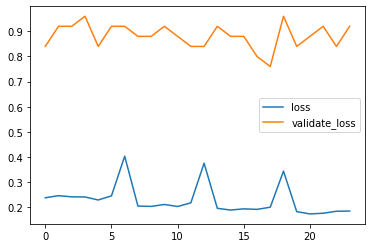

In [46]:
# plot some data
plt.plot(loss_history, label='loss')
plt.plot(dev_history, label='validate_loss')
plt.legend()

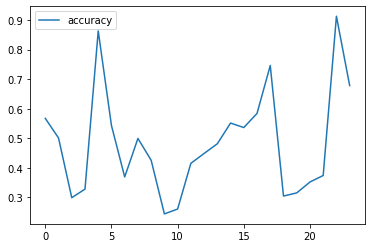

In [47]:
# accuracies
plt.plot(dev_acc_history, label='accuracy')
plt.legend()